# Predict TF overexpression effect

In [1]:
import pandas as pd
import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt

In [95]:
%load_ext autoreload
%autoreload

import cellregulondb as crdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1) Load data

### load single cell data

In [28]:
adata = scv.datasets.pancreas()

In [29]:
from mousipy import translate

In [30]:
adata = translate(adata)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27998/27998 [00:55<00:00, 505.24it/s]


Found direct orthologs for 16157 genes.
Found multiple orthologs for 559 genes.
Found no orthologs for 7560 genes.
Found no index in biomart for 3722 genes.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:06<00:00, 86.24it/s]


In [31]:
adata = adata[:,~adata.var['original_gene_symbol'].isna()]

In [32]:
adata

View of AnnData object with n_obs × n_vars = 3696 × 17031
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes', 'original_gene_symbol'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'

In [33]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

... storing 'original_gene_symbol' as categorical


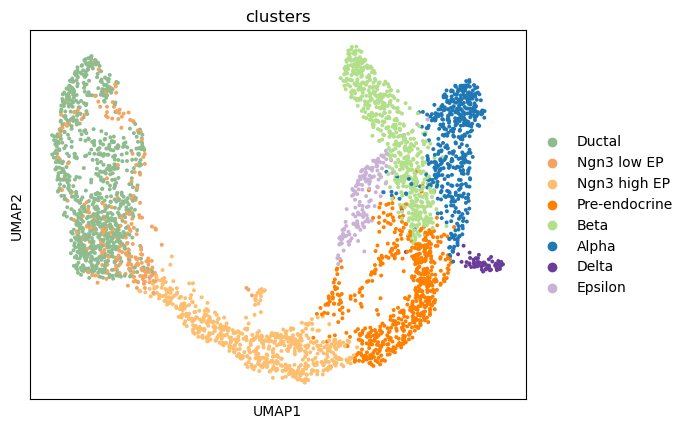

In [34]:
sc.pl.umap(adata, color='clusters')

### load regulon atlas

In [14]:
# crdb.download_db(version = 'latest', db_path='data/crdb.db')

[2024-06-04 21:39:26,341][INFO] Downloading database verssion 0.1.0


/Users/jp30/miniforge3_use/envs/cellregulon/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[2024-06-04 21:44:11,864][INFO] Downloaded data/crdb.db


'data/crdb.db'

In [49]:
db = crdb.CellRegulonDB("data/crdb.db")

list the available tissues (same for cell types, genes)

In [21]:
db.tissues.label.unique()

array(['heart', 'lung parenchyma', 'nose', 'respiratory airway', 'lung',
       'liver', 'transverse colon', 'skeletal muscle tissue', 'spleen',
       'thoracic lymph node', 'sigmoid colon', 'bone marrow', 'blood',
       'mesenteric lymph node', 'thymus', 'omentum', 'jejunal epithelium',
       'ileum', 'lamina propria', 'duodenum', 'caecum', 'hindlimb',
       'forelimb', 'skeletal muscle', 'esophagus muscularis mucosa',
       'skin', 'breast', 'esophagus mucosa', 'prostate gland',
       'ascending colon', 'small intestine', 'jejunum', 'stomach',
       'vermiform appendix', 'colon', 'descending colon',
       'saliva-secreting gland', 'buccal mucosa', 'gingiva',
       'periodontium', 'rectum', 'esophagus', 'intestine', 'muscle',
       'yolk sac', 'digestive tract', 'kidney', 'pancreas', 'eye',
       'bladder', 'tongue', 'vasculature', 'large intestine',
       'mammary gland', 'adipose tissue', 'lymph node', 'trachea',
       'uterus', 'vessel', 'decidua'], dtype=object)

We can select regulons for further analysis, e.g. using only lung regulons:

In [50]:
df = db.get_regulons(tissues = ["pancreas"])
df.head()

,transcription_factor,regulation,target_gene,tissue,cell_type,author_cell_type,coexpression,rss
0,AHR,-,KRT17,pancreas,endothelial cell,endothelial cell,0.485366,0.187896
1,ATF1,+,ERG,pancreas,endothelial cell,endothelial cell,4.221233,0.204936
2,ATF3,+,INHBB,pancreas,endothelial cell,endothelial cell,4.997968,0.177118
3,ATF3,+,SOX17,pancreas,endothelial cell,endothelial cell,2.572231,0.177118
4,ATF3,+,SOX7,pancreas,endothelial cell,endothelial cell,2.481867,0.177118


In [51]:
ra = crdb.RegulonAtlas()

In [52]:
ra.load_from_df(df)

To let the object know which annotation columns to use, we can set them like this:

In [53]:
ra.cell_type_col = "author_cell_type"

In [54]:
ra = ra.subset(regulons=ra.find_regulons(subset="n_genes > 5").index.tolist())

In [55]:
ra.save("data/regulons_pnc.h5ad")

... storing 'transcription_factor' as categorical
... storing 'regulation' as categorical
... storing 'tissue' as categorical
... storing 'cell_type' as categorical
... storing 'author_cell_type' as categorical


In [56]:
ra = crdb.RegulonAtlas.load_from_file('data/regulons_pnc.h5ad')

In [57]:
ra

RegulonAtlas object with 2082 regulons, 22 cell types and 3725 target genes.

## pred

In [35]:
crdb.ad.process(adata, groups='clusters', leiden_resolution=None)

In [36]:
crdb.ad.get_transition_genes(adata, group='clusters')

In [38]:
adata.uns['crdb']['transition_genes'].head()

XKR4  RP1  SOX17    MRPL15     RGS20  NPBWR1  SNTG1     MYBL1  \
0 1 -0.001094  0.0    0.0  0.001620  0.000000     0.0    0.0 -0.003278   
  2 -0.001094  0.0    0.0 -0.000155  0.001304     0.0    0.0 -0.003780   
1 0  0.001094  0.0    0.0 -0.001620  0.000000     0.0    0.0  0.003278   
  2  0.000000  0.0    0.0 -0.001775  0.001304     0.0    0.0 -0.000502   
2 0  0.001094  0.0    0.0  0.000155 -0.001304     0.0    0.0  0.003780   

       VCPIP1     TCF24  ...  ZNF772  ZNF134  RBMY1F  RBMY1B  RBMY1J  RBMY1A1  \
0 1 -0.002323  0.013385  ...     0.0     0.0     0.0     0.0     0.0      0.0   
  2 -0.004002 -0.005239  ...     0.0     0.0     0.0     0.0     0.0      0.0   
1 0  0.002323 -0.013385  ...     0.0     0.0     0.0     0.0     0.0      0.0   
  2 -0.001679 -0.018623  ...     0.0     0.0     0.0     0.0     0.0      0.0   
2 0  0.004002  0.005239  ...     0.0     0.0     0.0     0.0     0.0      0.0   

     RBMY1D  RBMY1E  SPIN2B  SPIN2A  
0 1     0.0     0.0     0.0     0.0  
  2     0.0     0.0     0.0     0.0  
1 0     0.0     0.0     0.0     0.0  
  2     0.0     0.0     0.0     0.0  
2 0     0.0     0.0     0.0     0.0  

[5 rows x 17031 columns]

In [125]:
ra.adata.obs.query("author_cell_type == 'pancreatic beta cell' and regulation == '+'").sort_values("n_genes", ascending=False)

,transcription_factor,regulation,tissue,cell_type,author_cell_type,rss,n_genes
HNF4A - (+) - pancreatic beta cell - pancreas,HNF4A,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.168296,41
OTX2 - (+) - pancreatic beta cell - pancreas,OTX2,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.169018,30
CRX - (+) - pancreatic beta cell - pancreas,CRX,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.169637,27
KDM5B - (+) - pancreatic beta cell - pancreas,KDM5B,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.167836,26
GATA6 - (+) - pancreatic beta cell - pancreas,GATA6,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.167953,25
FOXA2 - (+) - pancreatic beta cell - pancreas,FOXA2,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.168202,22
HNF4G - (+) - pancreatic beta cell - pancreas,HNF4G,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.168893,21
CDX2 - (+) - pancreatic beta cell - pancreas,CDX2,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.168988,18
GATA4 - (+) - pancreatic beta cell - pancreas,GATA4,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.168449,17
MAFB - (+) - pancreatic beta cell - pancreas,MAFB,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.167736,16


In [118]:
ra.find_regulons(transcription_factors=["PDX1", "NGN3", "NEUROD", "NKX6-1", "ISL1", "PAX6", "PAX4", "PAX2"])

,transcription_factor,regulation,tissue,cell_type,author_cell_type,rss,n_genes
ISL1 - (+) - fibroblast - pancreas,ISL1,+,pancreas,fibroblast,fibroblast,0.000000,6
ISL1 - (+) - pancreatic stellate cell - pancreas,ISL1,+,pancreas,pancreatic stellate cell,pancreatic stellate cell,0.178735,10
NKX6-1 - (+) - pancreatic alpha cell - pancreas,NKX6-1,+,pancreas,pancreatic A cell,pancreatic alpha cell,0.175597,12
NKX6-1 - (+) - pancreatic beta cell - pancreas,NKX6-1,+,pancreas,type B pancreatic cell,pancreatic beta cell,0.175211,14
NKX6-1 - (+) - pancreatic ductal cell - pancreas,NKX6-1,+,pancreas,pancreatic ductal cell,pancreatic ductal cell,0.247486,22
NKX6-1 - (+) - pancreatic pp cell - pancreas,NKX6-1,+,pancreas,pancreatic PP cell,pancreatic pp cell,0.169830,8
PDX1 - (+) - pancreatic ductal cell - pancreas,PDX1,+,pancreas,pancreatic ductal cell,pancreatic ductal cell,0.296421,10


In [107]:
regulon_dict = ra.get_target_genes_by(by="transcription_factor", subset='transcription_factor.isin(["PDX1", "NKX6-1", "ISL1"])')

In [109]:
regulon_dict = {k:v for k,v in regulon_dict.items() if len(v)>0}

In [110]:
regulon_dict

{'ISL1': ['BTBD3',
  'INS',
  'NGFR',
  'FAIM2',
  'FGF10',
  'HAND2',
  'HOXB5',
  'MEIS1',
  'NEXN',
  'NKX2-3',
  'PBX1',
  'SLIT2',
  'TCF21'],
 'NKX6-1': ['ST8SIA3',
  'PAK3',
  'CHGA',
  'ELAVL4',
  'NOL4',
  'NKX6-1',
  'NKX2-2',
  'MNX1',
  'SYT13',
  'PDX1',
  'LMO1',
  'FXYD6-FXYD2',
  'FRAS1',
  'FGFR2',
  'KCNJ16',
  'LINC00982',
  'FEV',
  'MEIS2',
  'FAP',
  'MYRF',
  'ETV4',
  'ESRRG',
  'ENC1',
  'ONECUT1',
  'ONECUT2',
  'CCND1',
  'CABP7',
  'PTPRN2',
  'SFRP5',
  'SLC4A4',
  'SORBS2',
  'C6',
  'C1QL1',
  'SYT6',
  'TTYH1'],
 'PDX1': ['CASR',
  'CLDN10',
  'DCDC2',
  'FXYD6-FXYD2',
  'KIF12',
  'MNX1',
  'NEURL3',
  'NTRK2',
  'PKHD1',
  'SLC4A4']}

In [111]:
crdb.ad.get_regulon_match(adata, regulon_genes=regulon_dict)

In [112]:
adata.uns['paga']#['transition_mat']

{'connectivities': <8x8 sparse matrix of type '<class 'numpy.float64'>'
 	with 28 stored elements in Compressed Sparse Row format>,
 'connectivities_tree': <8x8 sparse matrix of type '<class 'numpy.float64'>'
 	with 7 stored elements in Compressed Sparse Row format>,
 'groups': 'clusters',
 'PDX1_transitions': <8x8 sparse matrix of type '<class 'numpy.float64'>'
 	with 28 stored elements in Compressed Sparse Row format>,
 'pos': array([[-10.406792  ,   1.3948936 ],
        [ -9.194263  ,   0.07081768],
        [ -2.14749   ,  -3.9102793 ],
        [  4.868897  ,  -2.2960699 ],
        [  4.409221  ,   3.4373343 ],
        [  7.327534  ,   3.4933803 ],
        [  8.69422   ,  -1.1449916 ],
        [  2.7942102 ,   1.3833773 ]], dtype=float32),
 'ISL1_transitions': <8x8 sparse matrix of type '<class 'numpy.float64'>'
 	with 28 stored elements in Compressed Sparse Row format>,
 'NKX6-1_transitions': <8x8 sparse matrix of type '<class 'numpy.float64'>'
 	with 28 stored elements in Compress

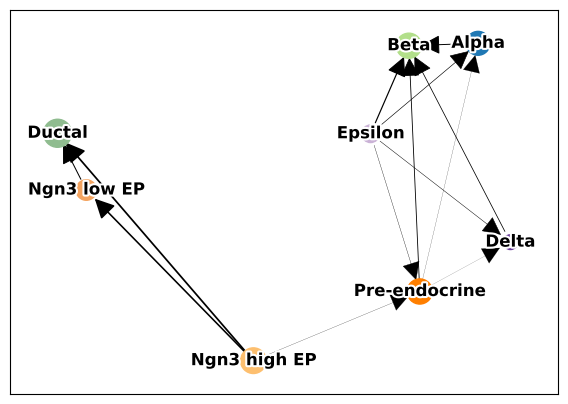

<Figure size 640x480 with 0 Axes>

In [116]:
crdb.ad.plot_transitions(adata, key="PDX1", color="clusters", edge_width_scale=5)

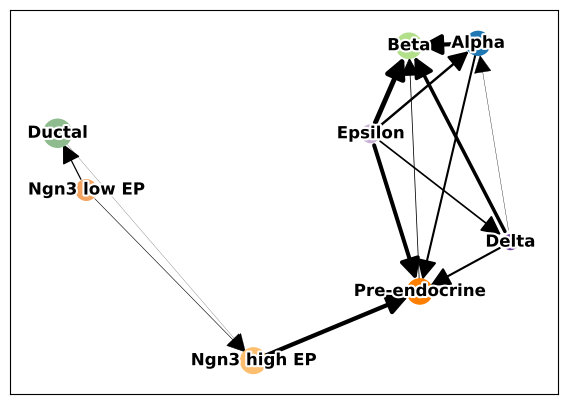

<Figure size 640x480 with 0 Axes>

In [117]:
crdb.ad.plot_transitions(adata, key="NKX6-1", color="clusters", edge_width_scale=5)

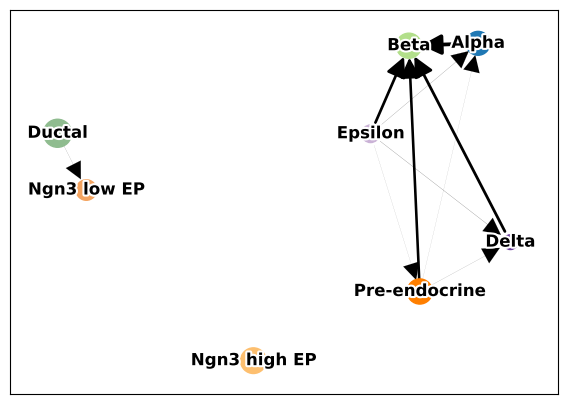

<Figure size 640x480 with 0 Axes>

In [115]:
crdb.ad.plot_transitions(adata, key="ISL1", color="clusters", edge_width_scale=5)